# Séance 2 : Opérations et nettoyage de données

Le but de la séance sera de nettoyer les données, mais aussi de connaître la distribution des données GPS Privamov

In [2]:
import pandas as pd
import glob
import gmaps
import gmaps.datasets
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from collections import Counter

In [3]:
path = "Data/Privamov/"
allFiles = glob.glob(path + "privamov*")
frame = pd.DataFrame()
list_= []

for file_ in allFiles:
    df = pd.read_csv(file_,sep="\t", header=None,  names = ["Id", "DateTime", "Longitude", "Latitude"])
    list_.append(df)
frame = pd.concat(list_)


### Tri des données en fonction du temps
Nous avons remarqué des vitesses négatives à la dernière séance. Ceci est sûrement dû au fait que les données ne sont pas forcément triées correctement. 

Il faudrait donc simplement faire un tri en fonction de la date et de l'heure pour avoir des vitesse positives ( mais pas encore égales à 0 pour la personne qui n'est pas censée bouger).

In [11]:
frame = frame.sort_values(by="DateTime")
frame.head()

,Id,DateTime,Longitude,Latitude
0,11,2014-12-07 05:20:23.792,4.871210,45.776037
1,1,2014-12-07 05:20:24.282,-97.750252,30.257248
2,1,2014-12-07 05:20:24.305,-97.750252,30.257248
3,11,2014-12-07 05:20:24.769,4.871210,45.776037
4,11,2014-12-07 05:20:24.789,4.871210,45.776037


### Calcul de la vitesse de l'id 1

On rappelle que la personne est censé dormir, donc la vitesse est censée être proche de 0.

In [127]:
frame1 = frame[frame["Id"] == 1]
len(frame1)
liste = []
for i in range(1, len(frame1)):
    deltaT = datetime.strptime(frame.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(frame.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
    if deltaT.total_seconds() == 0:
        continue
    iterloc1 = (frame1.Latitude.iloc[i], frame1.Longitude.iloc[i])
    iterloc2 = (frame1.Latitude.iloc[i], frame1.Longitude.iloc[i-1])

    speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
    liste.append(speed)


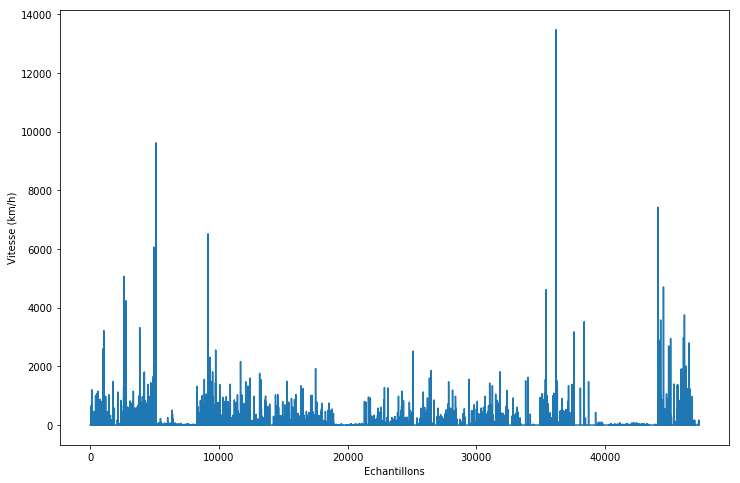

13473.096788207606

In [25]:
plt.figure(figsize=(12,8))
plt.xlabel('Echantillons')
plt.ylabel('Vitesse (km/h)')
plt.plot(liste)
plt.show()
max(liste)

##### Remarques et conclucsion
Les vitesse sont bien positives, mais elles sont beaucoup trop élevées pour certaines. Il faut donc continuer à nettoyer les données, ce que nous allons faire.

Mais avant cela, nous allons essayer de connaître la distribution du nombre de données envoyées par tranche de 5 minutes.

### Nombre de données par intervalle de 5 minutes pour l'id 1

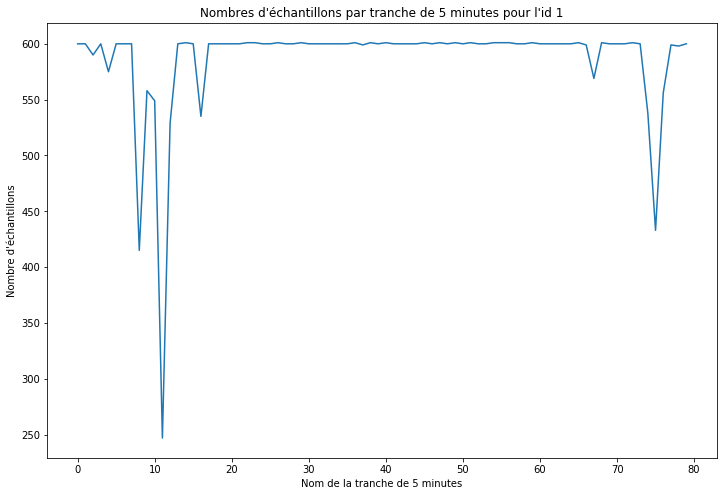

80
2014-12-07 05:20:24.282
2014-12-07 12:10:49.891


In [145]:
liste2 = []
frame1 = frame[frame["Id"] == 1]

current = datetime.strptime(frame1.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f')
counter = 0
counter2 = 0
d = timedelta(minutes = 5)
for i in range(1, len(frame1)):
    if datetime.strptime(frame1.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - current >= d:
        current = datetime.strptime(frame1.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f')
        liste2.append(counter+1)
        counter = 0
    else:
        counter = counter + 1
plt.figure(figsize=(12,8))
plt.xlabel('Nom de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 1")
plt.plot(liste2)
plt.show()
max(liste2)
print(len(liste2))
print(frame1.DateTime.min())
print(frame1.DateTime.max())

##### Remarques
On remarque donc que la plupart du temps, 600 données sont envoyées chaque intervalle de 5 minutes. C'est sûrement ce qui est désigné à la base.

Néanmoins, on remarque qu'il y a des intervalles ou très peu de données sont envoyées, peut-être dû à des problèmes de réseau.

On essaye ensuite de faire la même chose avec l'id 11.

### Nombre de données par intervalle de 5 minutes pour l'id 11

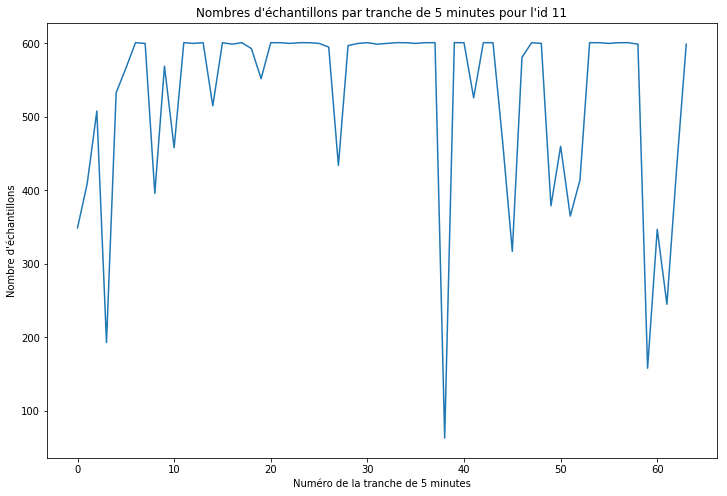

64
2014-12-07 05:20:23.792
2014-12-07 12:10:50.413


In [132]:
frame11 = frame[frame["Id"] == 11]
liste2 = []

current = datetime.strptime(frame11.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f')
counter = 0;
for i in range(1, len(frame11)):
    if str(datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - current) >= '0:05:00.000000':
        current = datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f')
        liste2.append(counter+1)
        counter = 0
    else:
        counter = counter + 1
        
        
plt.figure(figsize=(12,8))
plt.xlabel('Numéro de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 11")
plt.plot(liste2)
plt.show()
max(liste2)
print(len(liste2))
print(frame11.DateTime.min())
print(frame11.DateTime.max())

##### Remarques
Le maximum de nombre d'échantillon reste 600, c'est sûrement le nombre de données voulues par intervalles de 5 minutes.

On remarque qu'il y a un problème: 

Il n'y a en effet que 64 intervalles de 5 minutes, alors que nous avions qu'entre 5h20 et 12:10, il y en a 82.

Nous allons essayer de déterminer à quoi cela est dû.

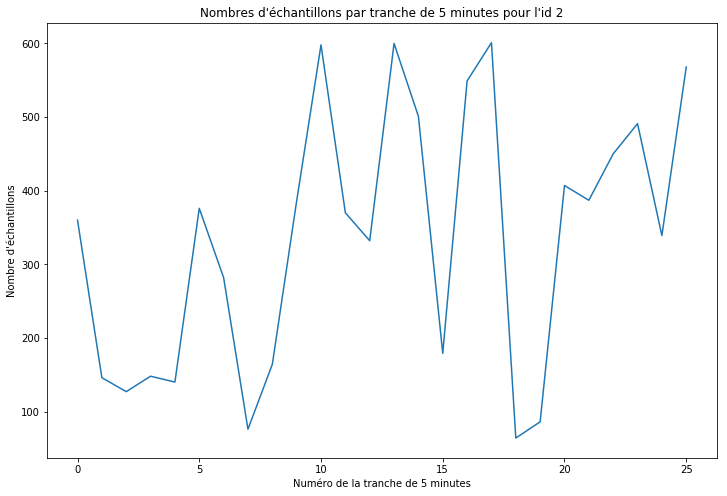

26
2014-12-07 06:21:43.095
2014-12-07 10:46:25.122


In [149]:
frame2 = frame[frame["Id"] == 2]
liste2 = []

current = datetime.strptime(frame2.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f')
counter = 0;
for i in range(1, len(frame2)):
    if str(datetime.strptime(frame2.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - current) >= '0:05:00.000000':
        current = datetime.strptime(frame2.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f')
        liste2.append(counter+1)
        counter = 0
    else:
        counter = counter + 1
        
        
plt.figure(figsize=(12,8))
plt.xlabel('Numéro de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 2")
plt.plot(liste2)
plt.show()
print(len(liste2))
print(frame2.DateTime.min())
print(frame2.DateTime.max())

##### Remarques
On remarque qu'il y a eu de nombreux problèmes lors de l'envoi des données, étant très loin des 600 sûrement voulus.

On remarque aussi que la dernière donnée à été envoyée 10h46 et la première à 6h21, différent de 12h10 et 5h20, ce qui montre un problème d'envoi de données ( coupure de réseau ? mode avion ?)

Essayons ensuite de déterminer pourquoi l'id 11, il nous manque des intervalles

### Nouvelle distribution de l'id 11

Une hypothèse que nous posons est qu'il y a un problème de réseau par intermittence: 

À certains moment, le portable ne va pas envoyer les données pendant un intervalle plus grand que 5 minutes, ce qui fausse l'algorithme utilisé précédemment, nous allons donc essayer de changer son fonctionnement.

In [13]:
frame11 = frame[frame["Id"] == 11]
liste2 = []
        
current = datetime.strptime(frame11.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = 5)
counter = 0
i = 0
while current  < datetime.strptime(frame11.DateTime.max(), '%Y-%m-%d %H:%M:%S.%f'):
    if datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
        counter = counter + 1
    elif datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') > current + timedelta(minutes = 5):
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes= 5)
    else:
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes = 5)
    i = i + 1
"""
for i in range(1, len(frame11)):
    if current  < datetime.strptime(frame11.DateTime.max(), '%Y-%m-%d %H:%M:%S.%f'):
        if datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
            counter = counter + 1
        elif datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') > current + timedelta(minutes = 5):
            liste2.append(counter)
            counter = 0
            current = current + timedelta(minutes= 5)
        else:
            liste2.append(counter)
            counter = 0
            current = current + timedelta(minutes = 5)
        i = i + 1
    else:
        break;
"""

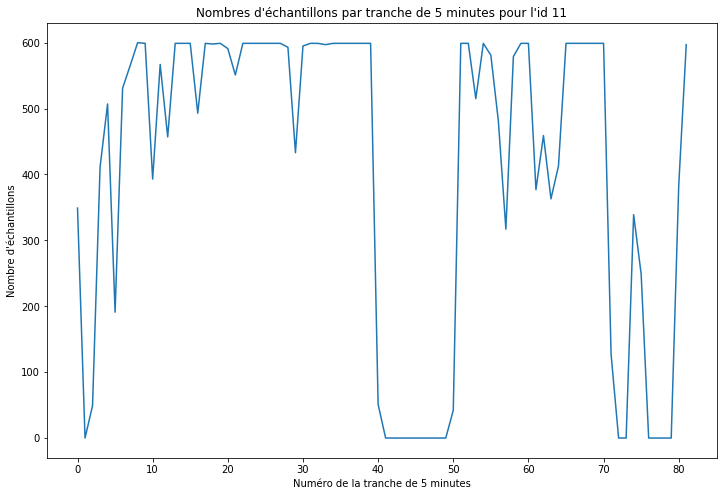

82
2014-12-07 05:20:23.792
2014-12-07 12:10:50.413


In [14]:
plt.figure(figsize=(12,8))
plt.xlabel('Numéro de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 11")
plt.plot(liste2)
plt.show()
max(liste2)
print(len(liste2))
print(frame11.DateTime.min())
print(frame11.DateTime.max())

##### Remarques

On remarque qu'il y a bien les 82 intervalles voulus, cet algo serait donc meilleur que l'autre dans le cas où les données ne sont pas forcément envoyées pendant un certain temps (bien que cet algo mette beaucoup plus de temps à s'exécuter).

On fait ensuite pareil pour les 2 autres id.

#### ID 1

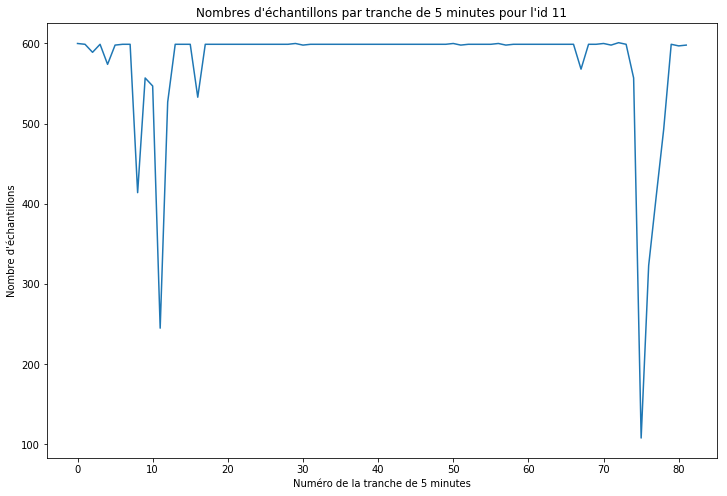

82
2014-12-07 05:20:24.282
2014-12-07 12:10:49.891


In [15]:
frame1 = frame[frame["Id"] == 1]
liste2 = []
        
current = datetime.strptime(frame1.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = 5)
counter = 0
i = 0
while current  < datetime.strptime(frame1.DateTime.max(), '%Y-%m-%d %H:%M:%S.%f'):
    if datetime.strptime(frame1.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
        counter = counter + 1
    elif datetime.strptime(frame1.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') > current + timedelta(minutes = 5):
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes= 5)
    else:
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes = 5)
    i = i + 1
    

plt.figure(figsize=(12,8))
plt.xlabel('Numéro de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 11")
plt.plot(liste2)
plt.show()
max(liste2)
print(len(liste2))
print(frame1.DateTime.min())
print(frame1.DateTime.max())

#### ID 2

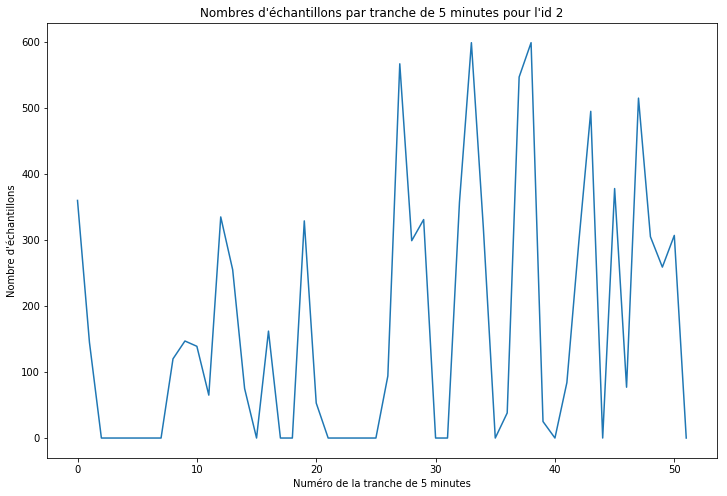

52
2014-12-07 06:21:43.095
2014-12-07 10:46:25.122


In [21]:
frame2 = frame[frame["Id"] == 2]
liste2 = []
        
current = datetime.strptime(frame2.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = 5)
counter = 0
i = 0
while current  < datetime.strptime(frame2.DateTime.max(), '%Y-%m-%d %H:%M:%S.%f'):
    if datetime.strptime(frame2.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
        counter = counter + 1
    elif datetime.strptime(frame2.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') > current + timedelta(minutes = 5):
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes= 5)
    else:
        liste2.append(counter)
        counter = 0
        current = current + timedelta(minutes = 5)
    i = i + 1
    
plt.figure(figsize=(12,8))
plt.xlabel('Numéro de la tranche de 5 minutes')
plt.ylabel('Nombre d\'échantillons')
plt.title("Nombres d'échantillons par tranche de 5 minutes pour l'id 2")
plt.plot(liste2)
plt.show()
max(liste2)
print(len(liste2))
print(frame2.DateTime.min())
print(frame2.DateTime.max())

###### Remarques et conclusion
Nous avons donc ici une distribution assez complète des données GPS, il manque néanmoins les deux extrémités de temps pour l'id 2, qui a des temps min et max différent des ids 1 et 11.

### Nettoyage
Nous allons finalement essayer de nettoyer les données.

Pour cela, nous n'avons pas vraiment d'algorithme en tête, néanmoins, nous allons essayer d'utiliser la méthode suivante:

Pour chaque intervalle d'une minute, nous allons prendre les latitudes et longitudes les plus communes, que nous mettrons ensuite dans une dataframe.

On essaye avec l'id 11.

On met tout d'abord les temps, les latitudes et longitudes dans 3 listes.

In [5]:
import statistics
listeLongitude = []
listeLatitude = []
listeTemps = []
listeLongitude2 = []
listeLatitude2 = []
frame11 = frame[frame["Id"] == 11]

current = datetime.strptime(frame11.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f')

d = timedelta(minutes = 1)
for i in range(1, len(frame11)):
    if datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - current >= d:
        listeTemps.append(current)
        current = datetime.strptime(frame11.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f')
        listeLongitude.append(statistics.mode(listeLongitude2))
        listeLatitude.append(statistics.mode(listeLatitude2))
    else:
        listeLongitude2 = []
        listeLatitude2 = []
        listeLongitude2.append(frame11.Longitude.iloc[i])
        listeLatitude2.append(frame11.Latitude.iloc[i])

On "ajoute" ensuite ces 3 listes dans une dataframe que l'on va sauvegarder dans un fichier texte.

In [6]:
df11 = pd.DataFrame(
    {'DateTime': listeTemps,
     'Longitude': listeLongitude,
     'Latitude': listeLatitude
    })
df11.head(10)
df11.DateTime.max()

Timestamp('2014-12-07 12:08:59.415000')

In [7]:
df11.to_csv("Data/Privamov/id11.txt", sep="\t", header=None)

## Conclusion

Cette séance nous a permis de voir la distribution des données et ainsi remarquer qu'il y a des problèmes au niveau de certaines données manquantes.

Nous avons aussi pu mettre en place un algorithme très basique de nettoyage de données.

Pour la séance suivante, nous essayerons de voir des algos de nettoyages plus poussés, et peut-être de passer aux données GPS autres que Privamov.